# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

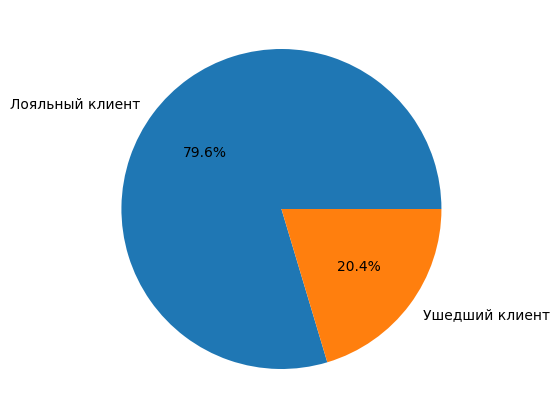

In [3]:
# заменяем цифры 1 и 0 в столбце Exited на их название
loyal = churn_data['Exited'].apply(lambda x: 'Лояльный клиент' if x == 0 else 'Ушедший клиент')
# подсчитываем число лояльных и ушедших клиентов - чтобы потом построить на этой основе круговую диаграмму
loyal_combination = loyal.value_counts()

# строим круговую диаграмму
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    loyal_combination, 
    labels=loyal_combination.index,
    autopct='%.1f%%' #отображаем соотношение в процентах
);

Видно, что классы не сбалансированы. Это значит, что для оценки качества работы логистической регрессии метрику accuracy использовать нельзя.

Посмотрим на распределение баланса клиентов в зависимости от лояльности:

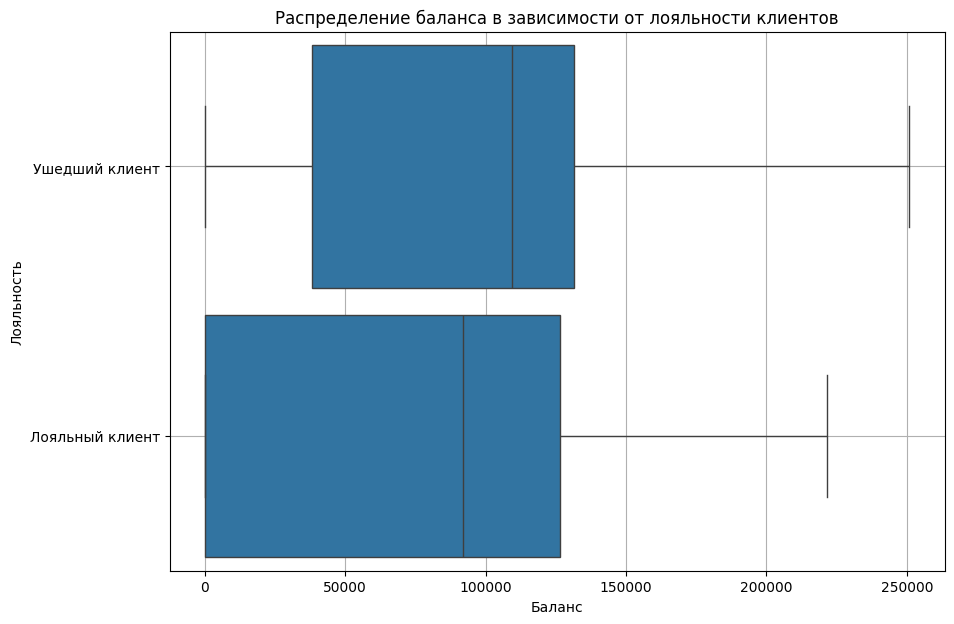

In [4]:
fig = plt.figure(figsize=(10, 7))

#строим коробчатую диаграмму
boxplot = sns.boxplot(
    data=churn_data,
    y=loyal, #здесь данные из признака Exited заменены на: 1 - Лояльный клиент, 0 - Ушедший клиент
    x='Balance', # по оси у откладываем баланс клиентов
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение баланса в зависимости от лояльности клиентов');
boxplot.set_xlabel('Баланс');
boxplot.set_ylabel('Лояльность');
boxplot.grid()

Среди лояльных клиентов разброс баланса больше, чем у ушедших клиентов, но при этом на балансе у многих лояльных клиентов меньше средств, чем у ушедших клиентов. Также видно, что медиана баланса у ушедших клиентов больше, чем у лояльных клиентов
Возможно, на отток клиентов влияет то, что они снимают с депозита деньги после того, как добились своих финансовых целей

Посмотрим на распределение возраста в разрезе оттока клиентов

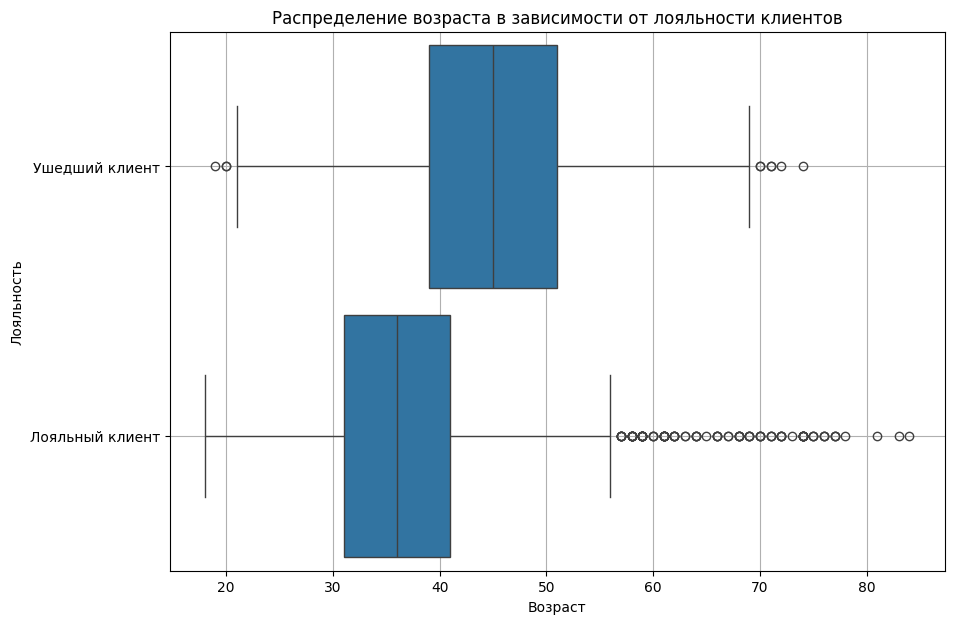

In [9]:
fig = plt.figure(figsize=(10, 7))

#строим коробчатую диаграмму
boxplot = sns.boxplot(
    data=churn_data,
    y=loyal, #здесь данные из признака Exited заменены на: 1 - Лояльный клиент, 0 - Ушедший клиент
    x='Age', # по оси у откладываем возраст клиентов
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение возраста в зависимости от лояльности клиентов');
boxplot.set_xlabel('Возраст');
boxplot.set_ylabel('Лояльность');
boxplot.grid()

Потенциальных выбросов больше в группе лояльных клиентов. Можно заметить, что ушедшие клиенты в среднем старше, чем лояльные клиенты. Банку следует обратить внимание на возрастную группу 30-40, потому что именно в ней больше вероятность, что клиент будет лояльным

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [5]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [6]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [7]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [8]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [12]:
# Создаем новые признаки по техзаданию
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/churn_data['Age']
# Кодируем категориальные признаки в числовые бинарные
churn_data = pd.get_dummies(churn_data, drop_first=True)
churn_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517,False
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889,True
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621,True
26,756,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000,True
28,574,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837,False


In [13]:
#Категориальный признак только один - пол. Заменим True и False данные в результирующем признаке на 1 и 0
churn_data['Gender_Male'] = churn_data['Gender_Male'].apply(lambda x: 1 if x else 0)
churn_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517,0
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889,1
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621,1
26,756,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000,1
28,574,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837,0


In [14]:
# Основные статистические характеристики итоговых признаков
churn_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487,0.524512
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558,0.499498
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676,0.000000
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275,0.000000
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143,1.000000
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941,1.000000
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889,1.000000


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [15]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [16]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [18]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [20]:
# Поскольку очистка данных от выбросов не производилась, воспользуемся RobustScaler
scaler = preprocessing.RobustScaler()
# обучение скейлера на тренировочной выборке
scaler.fit(X_train)
#трансформация признаков в соответствии с вычисленными параметрами
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Ваши рассуждения и ответ — *здесь*.

Для того, чтобы минимизировать ложноположительные срабатывания, нужно воспользоваться метрикой precision.
Однако для того, чтобы минимизировать ложноотрицательные срабатывания, нужно воспользоваться метрикой recall.

В нашем случае стоит задача минимизировать и ложноположительные, и ложноотрицательные срабатывания, значит, нам нужно высокое значение одновременно и метрики precision, и метрики recall. Обеспечить это может метрика F-мера с равным вкладом метрик precision и recall, то есть, вес метрики precision в расчете F-меры должен равняться 1.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).




















Maximum F1-score test = 0.4956772334293948 with C = 0.9
F1-score train = 0.5135658914728681 with C = 0.9


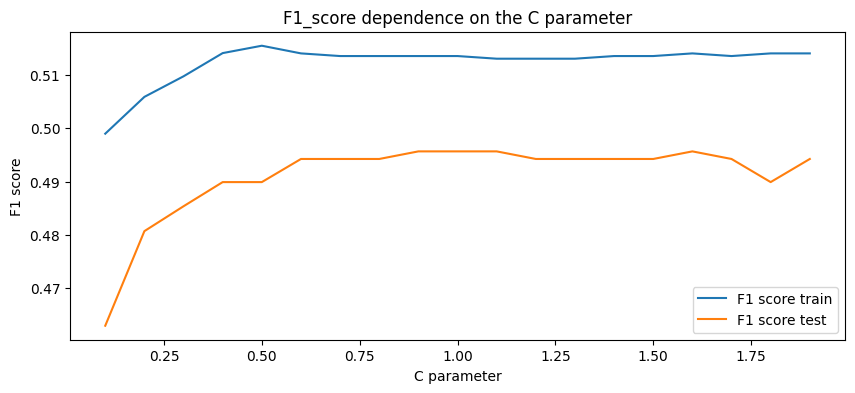

In [115]:
# Ваш код здесь
# Будем подбирать оптимальный параметр С для логистической регрессии
C_list = np.arange(0.1, 2, 0.1)

f1_score_train = []
f1_score_test = []

for c in C_list:
    #Создаем объект класса логистическая регрессия
    log_reg = linear_model.LogisticRegression(
        penalty='l2',
        C = c,
        random_state=42, #генератор случайных чисел,
        max_iter=1000
    )
    #Обучаем модель, минимизируя logloss
    log_reg.fit(X_train_scaled, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_pred = log_reg.predict(X_train_scaled)
    #Добавляем в массив F1-меры данные о предсказаниях на тренировочной выборке
    f1_score_train.append(metrics.f1_score(y_train, y_train_pred))
    #Делаем предсказание для тестовой выборки
    y_test_pred = log_reg.predict(X_test_scaled)
    #Добавляем в массив F1-меры данные о предсказаниях на тестовой выборке
    f1_score_test.append(metrics.f1_score(y_test, y_test_pred))
    print()

fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1-меры от параметра С на тренировочной выборке
ax.plot(C_list, f1_score_train, label='F1 score train')
#Строим линейный график зависимости F1-меры от параметра С на тестовой выборке
ax.plot(C_list, f1_score_test, label='F1 score test')
ax.set_title('F1_score dependence on the C parameter')
ax.set_xlabel('C parameter')
ax.set_ylabel('F1 score')
ax.legend()

max_value_f1_score_test = max(f1_score_test)
max_value_f1_score_test_index = f1_score_test.index(max_value_f1_score_test)

print(f'Maximum F1-score test = {max_value_f1_score_test} with C = {C_list[max_value_f1_score_test_index]}')
print(f'F1-score train = {f1_score_train[max_value_f1_score_test_index]} with C = {C_list[max_value_f1_score_test_index]}')

> Ваши выводы и рассуждения — *здесь*.


Максимальное значение F1-меры на тестовой выборке составляет приблизительно 0.496 при параметре С равном 0.9, этому значению соответствует F1-мера = 0.514 на тренировочной выборке. Большее значение параметра F1-меры для тестовой выборки получить не удалось.


Это значение немного отличается от целевого 0.5 - конечно, если округлить, оно будет равно 0.5, но на самом деле оно все равно немного меньше. 


Поэтому можно сделать вывод, что, строго говоря, <b>модель недообучена</b>. Учитывая, что соответствующее значение F1-меры на тренировочной выборке не сильно отличается от значения на тестовой выборке, говорить о переобученности нельзя. 

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).






























Maximum F1-score test = 0.6576086956521738 with C = 2.4000000000000004
F1-score train = 0.6862925482980681 with C = 2.4000000000000004


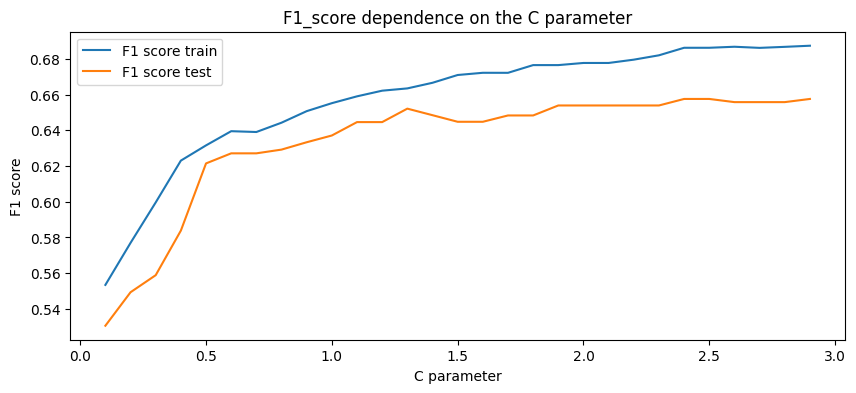

In [141]:
# Ваш код здесь

# Для масштабирования данных воспользуемся MinMaxScaler
scaler_mm = preprocessing.MinMaxScaler()
# обучение скейлера на тренировочной выборке
scaler_mm.fit(X_train)
#трансформация признаков в соответствии с вычисленными параметрами
X_train_scaled_mm = scaler_mm.transform(X_train)
X_test_scaled_mm = scaler_mm.transform(X_test)

#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled_mm)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled_mm)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled_mm)

#Создаем объект класса логистическая регрессия
C_list = np.arange(0.1, 3, 0.1)

f1_score_train = []
f1_score_test = []

for c in C_list:
    log_reg = linear_model.LogisticRegression(
        penalty='l2',
        C = c,
        random_state=42, #генератор случайных чисел,
        max_iter=1000
    )
    #Обучаем модель, минимизируя logloss
    log_reg.fit(X_train_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_pred = log_reg.predict(X_train_poly)
    #Добавляем в массив F1-меры данные о предсказаниях на тренировочной выборке
    f1_score_train.append(metrics.f1_score(y_train, y_train_pred))
    #Делаем предсказание для тестовой выборки
    y_test_pred = log_reg.predict(X_test_poly)
    #Добавляем в массив F1-меры данные о предсказаниях на тестовой выборке
    f1_score_test.append(metrics.f1_score(y_test, y_test_pred))
    print()

fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1-меры от параметра С на тренировочной выборке
ax.plot(C_list, f1_score_train, label='F1 score train')
#Строим линейный график зависимости F1-меры от параметра С на тестовой выборке
ax.plot(C_list, f1_score_test, label='F1 score test')
ax.set_title('F1_score dependence on the C parameter')
ax.set_xlabel('C parameter')
ax.set_ylabel('F1 score')
ax.legend()

max_value_f1_score_test = max(f1_score_test)
max_value_f1_score_test_index = f1_score_test.index(max_value_f1_score_test)

print(f'Maximum F1-score test = {max_value_f1_score_test} with C = {C_list[max_value_f1_score_test_index]}')
print(f'F1-score train = {f1_score_train[max_value_f1_score_test_index]} with C = {C_list[max_value_f1_score_test_index]}')

> Ваши выводы и рассуждения — *здесь*

Мы видим, что при использовании полиномиальных признаков удалось получить значение F1-меры приблизительно 0.658 на тестовой выборке при С = 2.4 и при соответствующем значении F1-меры приблизительно 0.686 на тренировочной выборке. Эти значения заметно больше, чем полученные без полиномиальных признаков; кроме того, нет признака переобучения модели.

Кроме того, эти значения больше целевого значения 0.5, заданного в предыдущем задании; значит, нам наконец-то удалось удовлетворить условия задачи.

<b>Вывод</b>: удалось улучшить результаты работы модели. 

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Optimal threshold = 0.30000000000000004
F1-score for test with optimal threshold = 0.7020408163265305
F1-score for train with optimal threshold= 0.7038567493112948


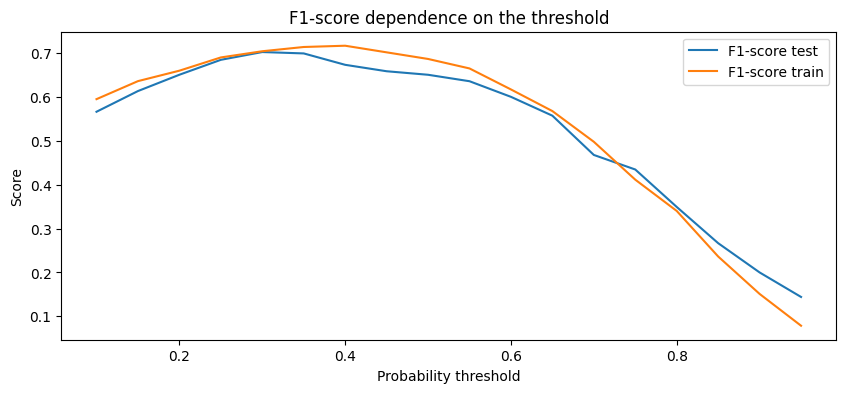

In [140]:
# Обучим модель логистической регрессии на данных с полиномиальными признаками и с рассчитанным ранее оптимальным значением параметра С

model = linear_model.LogisticRegression(
    penalty='l2',
    C = 2.4,
    random_state=42, #генератор случайных чисел,
    max_iter=1000
)
#Обучаем модель, минимизируя logloss
model.fit(X_train_poly, y_train)

thresholds = np.arange(0.1, 1, 0.05)

# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки и из тренировочной выборки
y_train_proba_pred = pd.Series(model.predict_proba(X_train_poly)[:, 1])
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем списки, куда будем сохранять метрики.
scores_train = []
scores_test = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score_test = metrics.f1_score(y_test, y_test_pred_poly)
    # Добавляем результат в список
    scores_test.append(score_test)
    # Делаем предсказание
    y_train_pred_poly = y_train_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score_train = metrics.f1_score(y_train, y_train_pred_poly)
    # Добавляем результат в список
    scores_train.append(score_train)
    
#Выводим оптимальное значение порога (при котором значение F1-меры для тестовой выборки максимально)   
print(f'Optimal threshold = {thresholds[scores_test.index(max(scores_test))]}')
    
fig, ax = plt.subplots(figsize=(10, 4)) 

#Строим линейный график зависимости F1-меры от threshold
ax.plot(thresholds, scores_test, label='F1-score test')
ax.plot(thresholds, scores_train, label='F1-score train')
ax.set_title('F1-score dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

#Задаем оптимальный порог вероятностей
threshold_opt = 0.3
#Людей, у которых вероятность покинуть банк больше 0.3 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(f'F1-score for test with optimal threshold = {metrics.f1_score(y_test, y_test_pred_opt)}')
print(f'F1-score for train with optimal threshold= {metrics.f1_score(y_train, y_train_pred_opt)}')

In [136]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.3
#Людей, у которых вероятность покинуть банк больше 0.3 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(f'F1-score with optimal threshold = {metrics.f1_score(y_test, y_test_pred_opt)}')
print(f'F1-score for train with optimal threshold for test = {metrics.f1_score(y_train, y_train_pred_opt)}')

F1-score with optimal threshold = 0.7020408163265305
F1-score for train with optimal threshold for test = 0.7038567493112948


<b>Вывод:</b>
Найден оптимальный порог для предсказания с оценкой точности при помощи метрики F1-меры: 0.3. Значение F1-меры на тренировочной и тестовой выборке с этим порогом почти совпадают.

Максимальное значение F1-меры на тестовой выборке, которого удалось достичь, округленно = 0.7. Можно считать, что поставленная задача выбранной моделью с учетом подобранного порога значения вероятности выполняется. 

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [142]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [143]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [144]:
# Ваш код здесь
# Создаем дерево решений с указанными параметрами
the_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Обучаем дерево решений
the_tree.fit(X_train, y_train)

# Делаем предсказания
y_train_tree_predict = the_tree.predict(X_train)
y_test_tree_predict = the_tree.predict(X_test)

# Рассчитываем метрику F1-score
print(f'Accuracy train = {metrics.f1_score(y_train, y_train_tree_predict)}')
print(f'Accuracy test = {metrics.f1_score(y_test, y_test_tree_predict)}')

Accuracy train = 1.0
Accuracy test = 0.5265822784810126


> Ваши выводы и рассуждения — *здесь*

Видно, что на тренировочной выборке значение метрики равно 1, в то время как на тестовой выборке значение метрики почти в два раза меньше.
Это говорит о переобучении модели.
Вероятно, это происходит из-за неограниченной глубины дерева: оно принимает во внимание все вообще факторы тренировочной выборки, но не улавливает общих тенденций

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [145]:
# Ваш код здесь
# Создаем дерево решений с указанными параметрами
the_tree_limited = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)

# Обучаем дерево решений
the_tree_limited.fit(X_train, y_train)

# Делаем предсказания
y_train_tree_predict = the_tree_limited.predict(X_train)
y_test_tree_predict = the_tree_limited.predict(X_test)

# Рассчитываем метрику F1-score
print(f'Accuracy train = {metrics.f1_score(y_train, y_train_tree_predict)}')
print(f'Accuracy test = {metrics.f1_score(y_test, y_test_tree_predict)}')

Accuracy train = 0.7172538392050587
Accuracy test = 0.6505376344086021


> Ваши выводы и рассуждения — *здесь*

В сравнении с результатами, полученными ранее, метрика для тренировочной выборки стала меньше, а для тестовой выборки - больше. Теперь модель не переобучена

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [146]:
# Ваш код здесь
# Создаем дерево решений с указанными параметрами
the_trees_ens = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)

# Обучаем дерево решений
the_trees_ens.fit(X_train, y_train)

# Делаем предсказания
y_train_tree_predict = the_trees_ens.predict(X_train)
y_test_tree_predict = the_trees_ens.predict(X_test)

# Рассчитываем метрику F1-score
print(f'Accuracy train = {metrics.f1_score(y_train, y_train_tree_predict)}')
print(f'Accuracy test = {metrics.f1_score(y_test, y_test_tree_predict)}')

Accuracy train = 0.7288135593220338
Accuracy test = 0.6446280991735537


> Ваши выводы и рассуждения — *здесь*

Метрика для тренировочной выборки стала чуть лучше, а для тестовой - чуть хуже. Улучшить метрику не удалось. 

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

Optimal threshold = 0.5000000000000001
F1-score for test with optimal threshold = 0.6505376344086021


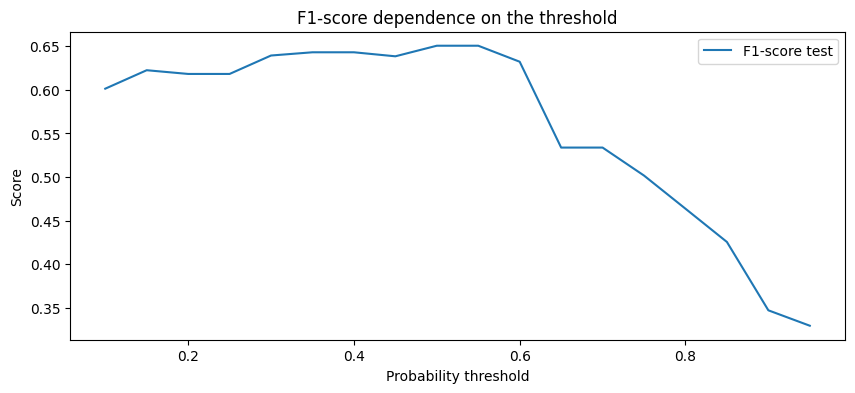

In [151]:
# Ваш код здесь
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(the_tree_limited.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred= y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_pred)
    # Добавляем результат в список
    scores.append(score)
    
#Выводим оптимальное значение порога (при котором значение F1-меры для тестовой выборки максимально)   
print(f'Optimal threshold = {thresholds[scores.index(max(scores))]}')
    
fig, ax = plt.subplots(figsize=(10, 4)) 

#Строим линейный график зависимости F1-меры от threshold
ax.plot(thresholds, scores, label='F1-score test')
ax.set_title('F1-score dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

#Задаем оптимальный порог вероятностей
threshold_opt = 0.5
#Людей, у которых вероятность покинуть банк больше 0.3 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(f'F1-score for test with optimal threshold = {metrics.f1_score(y_test, y_test_pred_opt)}')


> Ваши выводы и рассуждения — *здесь*

Оптимальным значением порога для тестовой выборки оказалось значение по умолчанию - 0.5. Значение метрики F1-score при этом пороге на тестовой выборке максимальное среди тех, которые удалось получить при помощи деревьев решений. В то же время эта метрика заметно меньше, чем полученная при рассчете при помощи логистической регрессии.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [167]:
# Ваш код здесь
# Вводим параметры клиента в отдельный ДатаФрейм
test_client = pd.DataFrame({'CreditScore':[601.0], 'Age': [42.0], 'Tenure': [1.0], 'Balance': [98495.72],
                            'NumOfProducts': [1.0], 'HasCrCard': [1.0], 'IsActiveMember': [0.0],'EstimatedSalary': [40014.76]})
#Добавляем дополнительные признаки
test_client['BalanceSalaryRatio'] = test_client['Balance']/test_client['EstimatedSalary']
test_client['TenureByAge'] = test_client['Tenure']/test_client['Age']
test_client['CreditScoreGivenAge'] = test_client['CreditScore']/test_client['Age']
#Переводим единственный категориальный признак в число простым добавлением столбца, поскольку клиент только один
test_client['Gender_Male'] = 1

# воспользуемся MinMaxScaler, обученным ранее, для обработки признаков тестового клиента
X_test_client_mm = scaler_mm.transform(test_client)

#Воспользуемся генератором полиномиальных признаков, обученным ранее, для генерации полиномиальных признаков для тестового клиента
X_test_client_poly = poly.transform(X_test_client_mm)

#Для предсказания вероятности оттока клиента воспользуемся моделью логистической регрессии, обученной ранее на полиномиальных признаках
y_test_client_proba_pred = pd.Series(model.predict_proba(X_test_client_poly)[:, 1])

print(f'Probability of class 1 = {y_test_client_proba_pred[0]}')


Probability of class 1 = 0.6565588311541212
